# Ydata Data Science School
## Linear Regression & Regularization Exercise.


## Outline
In this exercise you will learn the following topics:

1. Refresher on how linear regression is solved in batch and in Gradient Descent
2. Implementation of Ridge Regression
3. Comparing Ridge, Lasso and vanila Linear Regression on a dataset

## Refresher on Ordinary Least Square (OLS) aka Linear Regeression

### Lecture Note

In Matrix notation, the matrix $X$ is of dimensions $n \times p$ where each row is an example and each column is a feature dimension.

Similarily, $y$ is of dimension $n \times 1$ and $w$ is of dimensions $p \times 1$.

The model is $\hat{y}=X\cdot w$ where we assume for simplicity that $X$'s first columns equals to 1 (one padding), to account for the bias term.

Our objective is to optimize the loss $L$ defines as resiudal sum of squares (RSS):

$L_{RSS}=\frac{1}{N}\left\Vert Xw-y \right\Vert^2$ (notice that in matrix notation this means summing over all examples, so $L$ is scalar.)

To find the optimal $w$ one needs to derive the loss with respect to $w$.

$\frac{\partial{L_{RSS}}}{\partial{w}}=\frac{2}{N}X^T(Xw-y)$ (to see why, read about [matrix derivatives](http://www.gatsby.ucl.ac.uk/teaching/courses/sntn/sntn-2017/resources/Matrix_derivatives_cribsheet.pdf) or see class notes )

Thus, the gardient descent solution is $w'=w-\alpha \frac{2}{N}X^T(Xw-y)$.

Solving $\frac{\partial{L_{RSS}}}{\partial{w}}=0$ for $w$ one can also get analytical solution:

$w_{OLS}=(X^TX)^{-1}X^Ty$

The first term, $(X^TX)^{-1}X^T$ is also called the pseudo inverse of $X$.

See [lecture note from Stanford](https://web.stanford.edu/~mrosenfe/soc_meth_proj3/matrix_OLS_NYU_notes.pdf) for more details.


## Exercise 1 - Ordinary Least Square
* Get the boston housing dataset by using the scikit-learn package. hint: [load_boston](https://scikit-learn.org/0.15/modules/generated/sklearn.datasets.load_boston.html)

* What is $p$? what is $n$ in the above notation? hint: [shape](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.ndarray.shape.html)

* write a model `OrdinaryLinearRegression` which has a propoery $w$ and 3 methods: `fit`, `predict` and `score` (which returns the MSE on a given sample set). Hint: use [numpy.linalg.pinv](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.linalg.pinv.html) to be more efficient.

* Fit the model. What is the training MSE?

* Plot a scatter plot where on x-axis plot $Y$ and in the y-axis $\hat{Y}_{OLS}$

* Split the data to 75% train and 25% test 20 times. What is the average MSE now for train and test? Hint: use [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) or [ShuffleSplit](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html).

* Use a t-test to proove that the MSE for training is significantly smaller than for testing. What is the p-value? Hint: use [scipy.stats.ttest_rel](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.ttest_rel.html).

* Write a new class `OrdinaryLinearRegressionGradientDescent` which inherits from `OrdinaryLinearRegression` and solves the problem using gradinet descent. The class should get as a parameter the learning rate and number of iteration. Plot the class convergance. What is the effect of learning rate? How would you find number of iteration automatically? Note: Gradient Descent does not work well when features are not scaled evenly (why?!). Be sure to normalize your features first.

* The following parameters are optional (not mandatory to use):
    * early_stop - True / False boolean to indicate to stop running when loss stops decaying and False to continue.
    * verbose- True/False boolean to turn on / off logging, e.g. print details like iteration number and loss (https://en.wikipedia.org/wiki/Verbose_mode)
    * track_loss - True / False boolean when to save loss results to present later in learning curve graphs

In [36]:
# * write a model `Ols` which has a propoery $w$ and 3 methods: `fit`, `predict` and `score`.? hint: use [numpy.linalg.pinv](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.linalg.pinv.html) to be more efficient.
import numpy as np
import torch

class Ols(object):
  def __init__(self):
    self.w = None

  @staticmethod
  def pad(X):
    n, m = X.shape  
    ones = np.ones((n, 1))
    return np.concatenate([X, ones], axis=1)

  def fit(self, X, Y):
   self._fit(X, Y)
 
  def _fit(self, X, Y):
    X2 = self.pad(X)
    X_transp_dot = np.dot(X2.T, X2)
    X_inv = np.linalg.inv(X_transp_dot) 
    X_inv_X = np.dot(X_inv, X2.T)
    result = np.dot(X_inv_X, Y)
    self.w = result.flatten()

  def predict(self, X):
    return self._predict(X)
 
  def _predict(self, X):
    coef = np.dot(self.pad(X), self.w)
    return coef.flatten()

  def score(self, X, Y):
    Y_pred = self.predict(X)
    MSE = Y - Y_pred
    MSE = np.mean(MSE**2)
    return MSE

In [365]:
# Write a new class OlsGd which solves the problem using gradinet descent.
# The class should get as a parameter the learning rate and number of iteration.
# Plot the loss convergance. for each alpha, learning rate plot the MSE with respect to number of iterations.
# What is the effect of learning rate?
# How would you find number of iteration automatically?
# Note: Gradient Descent does not work well when features are not scaled evenly (why?!). Be sure to normalize your feature first.
class Normalizer():
  def __init__(self):
    pass

  def fit(self, X):
    #self.X_min = np.min(X, axis=0)
    #self.X_max = np.max(X, axis=0)
    self.mean = np.mean(X, axis=0)
    self.std = np.std(X, axis=0)
    
  def predict(self, X):
    return (X - self.mean) / self.std
    

class OlsGd(Ols):

  def __init__(self, learning_rate=.05,
               num_iteration=1000,
               normalize=True,
               early_stop=True,
               verbose=True):

    super(OlsGd, self).__init__()
    self.learning_rate = learning_rate
    self.num_iteration = num_iteration
    self.early_stop = early_stop
    self.normalize = normalize
    self.normalizer = Normalizer()
    self.verbose = verbose

  def _fit(self, X, Y, reset=True, track_loss=True):
    if self.normalize:
        self.normalizer.fit(X)
        X_norm = self.normalizer.predict(X)
    else:
        X_norm = X
    X_norm = self.pad(X_norm)

    n, m = X_norm.shape
    w = np.random.randn(m)*0.01
    self.losses = []
    for i in range(self.num_iteration):
        loss = np.dot(X_norm, w) - Y
        w_new = self.learning_rate/n*(np.dot(X_norm.T, loss))
        if self.early_stop and np.linalg.norm(w_new - w) < 1e-6:
            break
        if track_loss:
            self.losses.append(loss)
        w = w - w_new
        if self.verbose:
            print("Weights: {}, loss: {}".format(w, loss))
    self.w = w


  def _predict(self, X):
    if self.normalize:
        self.normalizer.fit(X)
        X_norm = self.normalizer.predict(X)
    else:
        X_norm = X
    coef = np.dot(self.pad(X_norm), self.w)
    return coef.flatten()  

  def _step(self, X, Y):
    # use w update for gradient descent
    pass

In [204]:
import pandas as pd

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]
data.shape

(506, 13)

In [41]:
boston_model = Ols()
boston_model.fit(data, target)
boston_model.w
target_pred = boston_model.predict(data)
#print(boston_model.Y_pred)
boston_model.score(data, target)

21.894831181729206

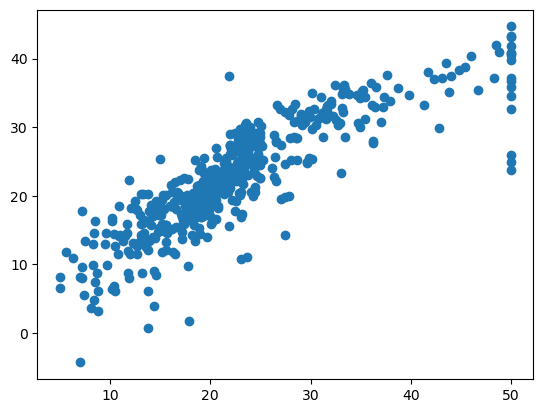

In [42]:
import matplotlib.pyplot  as plt

plt.scatter(target, target_pred)
plt.show()


In [26]:
from sklearn.model_selection import train_test_split

MSE_train = []
MSE_test = []
for i in range(20):
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25)
    boston_model.fit(X_train, y_train)
    #boston_model.predict(X_test)
    MSE_train.append(boston_model.score(X_train, y_train))
    MSE_test.append(boston_model.score(X_test, y_test))

np.mean(MSE_train), np.mean(MSE_test)

(21.988933254529364, 22.663321703517536)

In [27]:
from scipy.stats import ttest_rel

t_stat, p_value = ttest_rel(MSE_train, MSE_test)
p_value

0.6409545765239081

MSE for the test dataset is not significantly different from the MSE of the training dataset

In [370]:
boston_model_OlsGd = OlsGd(verbose=False)
boston_model_OlsGd.fit(data, target)
boston_model_OlsGd.predict(data)
boston_model_OlsGd.score(data, target)

21.89608628566295

## Exercise 2 - Ridge Linear Regression

Recall that ridge regression is identical to OLS but with a L2 penalty over the weights:

$L(y,\hat{y})=\sum_{i=1}^{i=N}{(y^{(i)}-\hat{y}^{(i)})^2} + \lambda \left\Vert w \right\Vert_2^2$

where $y^{(i)}$ is the **true** value and $\hat{y}^{(i)}$ is the **predicted** value of the $i_{th}$ example, and $N$ is the number of examples

* Show, by differentiating the above loss, that the analytical solution is $w_{Ridge}=(X^TX+\lambda I)^{-1}X^Ty$
* Change `OrdinaryLinearRegression` and `OrdinaryLinearRegressionGradientDescent` classes to work also for ridge regression. Either add a parameter, or use inheritance.
* **Bonus: Noise as a regularizer**: Show that OLS (ordinary least square), if one adds multiplicative noise to the features the **average** solution for $W$ is equivalent to Ridge regression. In other words, if $X'= X*G$ where $G$ is an uncorrelated noise with variance $\sigma$ and mean 1, then solving for $X'$ with OLS is like solving Ridge for $X$. What is the interpretation?



In [372]:
class RidgeLs(Ols):
  def __init__(self, ridge_lambda, *wargs, **kwargs):
    super(RidgeLs,self).__init__(*wargs, **kwargs)
    self.ridge_lambda = ridge_lambda

  def _fit(self, X, Y):
    X2 = self.pad(X)
    I = np.eye(X2.shape[1])
    X_transp_dot = np.dot(X2.T, X2) + self.ridge_lambda * I
    X_inv = np.linalg.inv(X_transp_dot) 
    X_inv_X = np.dot(X_inv, X2.T)
    result = np.dot(X_inv_X, Y)
    self.w = result.flatten()


In [373]:
X = np.array([[2, 1, 4], [3, 6, 2], [7, 2, 4], [6, 1, 1], [2, 5, 3]])
Y = np.array([2, 4, 6, 4, 3])

In [376]:
model = RidgeLs(0)
model.fit(X, Y)
model.predict(X)
#model.score(X, Y)


array([1.95652174, 3.91304348, 6.        , 4.02173913, 3.10869565])

In [379]:
model = Ols()
model.fit(X+2, Y)
model.predict(X+2)

array([1.95652174, 3.91304348, 6.        , 4.02173913, 3.10869565])

In [459]:
mean = 1
var = 0.5
noise = np.random.normal(mean, np.sqrt(var), data.shape)
model.fit(data*noise, target)
model.w
#model.predict(X*noise)

array([-1.66491482e-01,  5.55525598e-02, -1.06827694e-01,  3.72444140e+00,
       -1.35339544e+00,  5.54659101e-02, -1.73117837e-03, -1.70621051e-01,
       -7.88189966e-02, -1.73055050e-03, -2.78166437e-02,  1.11452965e-03,
       -1.87035937e-01,  2.85415675e+01])

In [461]:
model_ridge = RidgeLs(0.5)
model_ridge.fit(data, target)
#model_ridge.predict(data)
model_ridge.w

array([-1.01304345e-01,  4.76876713e-02, -9.35145275e-04,  2.67839879e+00,
       -9.53458233e+00,  4.55628720e+00, -4.72229023e-03, -1.25527690e+00,
        2.52616327e-01, -1.15821310e-02, -7.25666863e-01,  1.14008233e-02,
       -4.91429242e-01,  2.17626552e+01])

### Use scikitlearn implementation for OLS, Ridge and Lasso